In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
torch.multiprocessing.set_start_method('spawn')

import sys,os

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

import glob
import xarray as xr
import datetime

# import yaml
import tqdm
import time
import torchvision

import pickle
import joblib
import logging
import random

from typing import List, Dict, Callable, Union, Any, TypeVar, Tuple
# from multiprocessing import cpu_count

import torch.fft
from torch import nn

import torch.nn.functional as F

# from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.models as models
from torch.optim.lr_scheduler import *

from sklearn.model_selection import train_test_split

from collections import defaultdict
import pandas as pd

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True
    #torch.backends.cudnn.deterministic = True

In [4]:
class ResNet(nn.Module):
    def __init__(self, fcl_layers = [], dr = 0.0, output_size = 1, resnet_model = 18, pretrained = True):
        super(ResNet, self).__init__()
        self.pretrained = pretrained
        self.resnet_model = resnet_model 
        if self.resnet_model == 18:
            resnet = models.resnet18(pretrained=self.pretrained)
        elif self.resnet_model == 34:
            resnet = models.resnet34(pretrained=self.pretrained)
        elif self.resnet_model == 50:
            resnet = models.resnet50(pretrained=self.pretrained)
        elif self.resnet_model == 101:
            resnet = models.resnet101(pretrained=self.pretrained)
        elif self.resnet_model == 152:
            resnet = models.resnet152(pretrained=self.pretrained)
        resnet.conv1 = torch.nn.Conv1d(2, 64, (7, 7), (2, 2), (3, 3), bias=False) # Manually change color dim to match our data
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet_output_dim = resnet.fc.in_features
        self.resnet = nn.Sequential(*modules)
        self.fcn = self.make_fcn(self.resnet_output_dim, output_size, fcl_layers, dr)
        
    def make_fcn(self, input_size, output_size, fcl_layers, dr):
        if len(fcl_layers) > 0:
            fcn = [
                nn.Dropout(dr),
                nn.Linear(input_size, fcl_layers[0]),
                nn.BatchNorm1d(fcl_layers[0]),
                torch.nn.LeakyReLU()
            ]
            if len(fcl_layers) == 1:
                fcn.append(nn.Linear(fcl_layers[0], output_size))
            else:
                for i in range(len(fcl_layers)-1):
                    fcn += [
                        nn.Linear(fcl_layers[i], fcl_layers[i+1]),
                        nn.BatchNorm1d(fcl_layers[i+1]),
                        torch.nn.LeakyReLU(),
                        nn.Dropout(dr)
                    ]
                fcn.append(nn.Linear(fcl_layers[i+1], output_size))
        else:
            fcn = [
                nn.Dropout(dr),
                nn.Linear(input_size, output_size)
            ]
        if output_size > 1:
            fcn.append(torch.nn.LogSoftmax(dim=1))
        return nn.Sequential(*fcn)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fcn(x)
        return x

In [32]:
class InferencePropagator:
    
    def __init__(self, 
                 data_path,
                 n_bins = 1000, 
                 tile_size = 512, 
                 step_size = 128, 
                 marker_size = 10, 
                 device = "cuda"):
        
        self.h_ds = xr.open_dataset(data_path)
        self.n_bins = n_bins
        self.z_bins = np.linspace(self.h_ds.attrs['zMin'],self.h_ds.attrs['zMax'],n_bins+1)*1e6  # histogram bin edges
        self.z_centers = self.z_bins[:-1] + 0.5*np.diff(self.z_bins)  # histogram bin centers

        self.tile_size = tile_size  # size of tiled images in pixels
        self.step_size = step_size  # amount that we shift the tile to make a new tile
        self.marker_size = marker_size # UNET gaussian marker width (standard deviation) in um
        self.device = device

        # step_size is not allowed be be larger than the tile_size
        assert self.tile_size >= self.step_size

        self.dx = self.h_ds.attrs['dx']      # horizontal resolution
        self.dy = self.h_ds.attrs['dy']      # vertical resolution
        self.Nx = int(self.h_ds.attrs['Nx']) # number of horizontal pixels
        self.Ny = int(self.h_ds.attrs['Ny']) # number of vertical pixels
        self.lam = self.h_ds.attrs['lambda'] # wavelength
        self.zMin = self.h_ds.attrs['zMin']  # minimum z in sample volume
        self.zMax = self.h_ds.attrs['zMax'] 
        self.image_norm = 255.0

        self.x_arr = np.arange(-self.Nx//2, self.Nx//2)*self.dx
        self.y_arr = np.arange(-self.Ny//2, self.Ny//2)*self.dy
        
        self.fx = None
        self.fy = None

    
    def compute_f(self):
        self.fx = torch.fft.fftfreq(self.Nx,self.dx,device=self.device).unsqueeze(0).unsqueeze(2)
        self.fy = torch.fft.fftfreq(self.Ny,self.dy,device=self.device).unsqueeze(0).unsqueeze(1)
        
    
    def torch_holo_set(self, 
                       Ein: torch.tensor,
                       z_tnsr: torch.tensor):
        """
        Propagates an electric field a distance z
        Ein complex torch.tensor
        - input electric field

        fx:real torch.tensor
        - x frequency axis (3D, setup to broadcast)

        fy: real torch.tensor
        - y frequency axis (3D, setup to broadcast)

        z_tnsr: torch.tensor
        - tensor of distances to propagate the wave Ein
            expected to have dims (Nz,1,1) where Nz is the number of z
            dimensions

        lam: float
        - wavelength

        returns: complex torch.tensor with dims (Nz,fy,fx)

        Note the torch.fft library uses dtype=torch.complex64
        This may be an issue for GPU implementation

        """
        if self.fx is None:
            self.compute_f()
        
        Etfft = torch.fft.fft2(Ein)
        Eofft = Etfft*torch.exp(1j*2*np.pi*z_tnsr/self.lam*torch.sqrt(1-self.lam**2*(self.fx**2+self.fy**2)))

        # It might be helpful if we could omit this step.  It would save an inverse fft.
        Eout = torch.fft.ifft2(Eofft)

        return Eout
    
    def get_sub_images(self, image_tnsr, z_sub_set, z_counter):
        """
        Reconstruct z_sub_set planes from
        the original hologram image and
        split it into tiles of size
        tile_size

        image - 3D tensor on device to reconstruct
        z_sub_set - array of z planes to reconstruct in one batch
        z_counter - counter of how many z images have been reconstructed

        Returns 
            Esub - a list of complex tiled images 
            image_index_lst - tile index of the sub image (x,y,z)
            image_corner_coords - x,y coordinates of the tile corner (starting values)
            z_pos - the z position of the plane in m
        """
        # build the torch tensor for reconstruction
        z_plane = torch.tensor(z_sub_set*1e-6, device=self.device).unsqueeze(-1).unsqueeze(-1)

        # reconstruct the selected planes
        E_out = self.torch_holo_set(image_tnsr, z_plane).detach().cpu().numpy()

#         Esub = []
#         z_pos = []
#         image_corner_coords = []
#         image_index_lst = []

#         for z_idx in range(E_out.shape[0]):
#             for row_idx in range(0,E_out.shape[1]//self.step_size):
#                 for col_idx in range(0,E_out.shape[2]//self.step_size):
#                     Esub.append(E_out[z_idx,row_idx:row_idx+self.tile_size,col_idx:col_idx+self.tile_size])
#                     z_pos.append(z_sub_set[z_idx]*1e-6)
#                     image_corner_coords.append([self.x_arr[row_idx*self.step_size], self.y_arr[col_idx*self.step_size]])
#                     image_index_lst.append([row_idx,col_idx,z_idx+z_counter])
#         return Esub, image_index_lst, image_corner_coords, z_pos
    
        Esub = []
        z_pos = []
        image_corner_coords = []
        image_index_lst = []

        for z_idx in range(E_out.shape[0]):
            for row_idx in range(0,E_out.shape[1]//self.step_size):
                if row_idx*self.step_size+self.tile_size > E_out.shape[1]:
                    row_slice = slice(-self.tile_size,None)
                    row_break = True
                else:
                    row_slice = slice(row_idx*self.step_size,row_idx*self.step_size+self.tile_size)
                    row_break = False

                for col_idx in range(0,E_out.shape[2]//self.step_size):
                    if col_idx*self.step_size+self.tile_size > E_out.shape[2]:
                        col_slice = slice(-self.tile_size,None)
                        col_break = True
                    else:
                        col_slice = slice(col_idx*self.step_size,col_idx*self.step_size+self.tile_size)
                        col_break = False

                    Esub.append(E_out[z_idx,row_slice,col_slice])
                    if Esub[-1].shape != (self.tile_size,self.tile_size):
                        print(f"Incorrect image size in tile: {Esub[-1].shape} ")

                    z_pos.append(z_sub_set[z_idx]*1e-6)
                    image_corner_coords.append([self.x_arr[row_slice][0], self.y_arr[col_slice][0]])
                    image_index_lst.append([row_idx,col_idx,z_idx+z_counter])

                    if col_break:
                        break

                if row_break:
                    break

        return Esub, image_index_lst, image_corner_coords, z_pos
    
    
    def get_next_z_planes(self, input_image, z_planes_lst):
        """
        Generator that returns reconstructed z patches
        image - 2D image array of the original captured hologam 
        z_planes_lst - list containing batchs of arrays of z positions to reconstruct
            create_z_plane_lst() will provide this for a desired batch size and set
            planes

        returns:
            sub_image - list of sub images
            image_index_lst - list of tile indicies to the sub image
            image_coords - x,y corner coordinates of the sub images
            image_z - z location of the sub image in m
        """

        z_counter = 0 # the number of planes reconstructed in this generator
        image_tnsr = torch.tensor(input_image.values, device=self.device).unsqueeze(0)
        for z_sub_set in z_planes_lst:
            sub_image, image_index_lst, image_coords, image_z = self.get_sub_images(image_tnsr,z_sub_set,z_counter)
            z_counter+=z_sub_set.size
            yield sub_image, image_index_lst, image_coords, image_z
            
    def create_z_plane_lst(self, planes_per_call=1):
        """
        Create a list of z planes according to the requested
        batch size.  This generates the z_planes_lst argument
        needed for gen_next_z_plane()
        """
        z_lst = []
        for z_idx in np.arange(0, self.z_centers.size, planes_per_call):
            z_lst.append(self.z_centers[z_idx:(z_idx+planes_per_call)])
        return z_lst

In [33]:
synthetic_path = "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_500particle_gamma_4872x3248_training.nc"

n_bins = 1000  # number of bins in histogram
tile_size = 512  # size of tiled images in pixels
step_size = 128  # amount that we shift the tile to make a new tile
marker_size = 10 # UNET gaussian marker width (standard deviation) in um

In [34]:
prop = InferencePropagator(
    synthetic_path, 
    n_bins = n_bins,
    tile_size = tile_size,
    step_size = step_size,
    marker_size = marker_size,
    device = device
)

In [35]:
h_idx = 23
test_image = prop.h_ds['image'].isel(hologram_number=h_idx)

In [36]:
z_list = prop.create_z_plane_lst(planes_per_call=1)

In [37]:
#chunked_z_list = np.array_split(z_list, 8)

<All keys matched successfully>

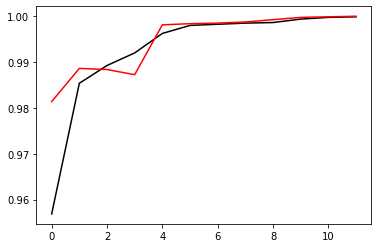

In [38]:
# Load a model

model_loc = "./" #"z10000"
f = pd.read_csv(f"{model_loc}/training_log_resnet.csv")
plt.plot(f["epoch"], f["train_accuracy"], c = 'k')
plt.plot(f["epoch"], f["valid_accuracy"], c = 'r')


fcl_layers = []
dropout = 0.2
output_size = 2
resnet_model = 50
pretrained = True

model = ResNet(fcl_layers, 
               dr = dropout, 
               output_size = output_size, 
               resnet_model=resnet_model, 
               pretrained = pretrained).to(device)


checkpoint = torch.load(
    f"{model_loc}/best_resnet.pt",
    map_location=lambda storage, loc: storage
)
model.load_state_dict(checkpoint["model_state_dict"])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [47]:
z_list_sample = random.sample(z_list, 50)

inference_generator = prop.get_next_z_planes(test_image, z_list_sample)

  0%|          | 0/1000 [00:00<?, ?it/s]

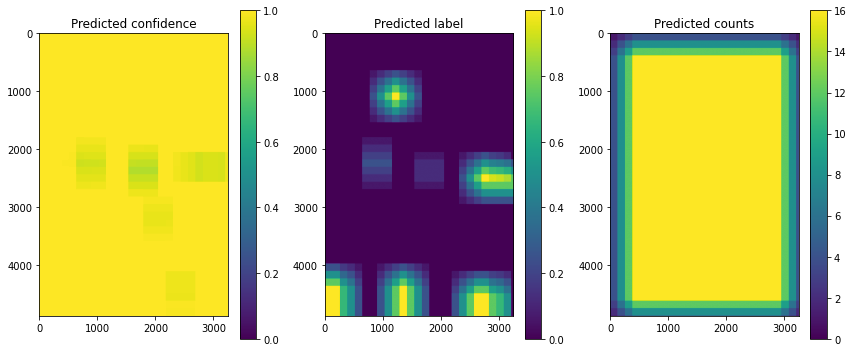

  0%|          | 1/1000 [00:08<2:15:40,  8.15s/it]

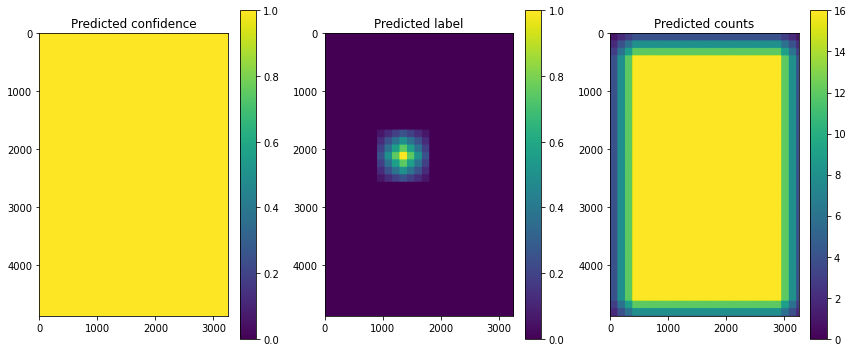

  0%|          | 2/1000 [00:16<2:14:19,  8.08s/it]

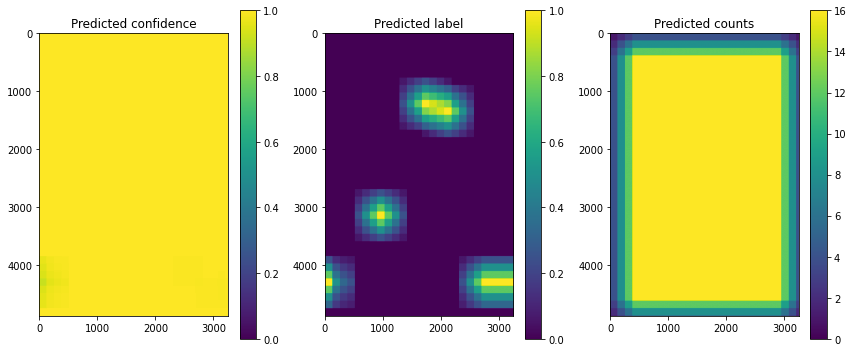

  0%|          | 3/1000 [00:24<2:13:32,  8.04s/it]

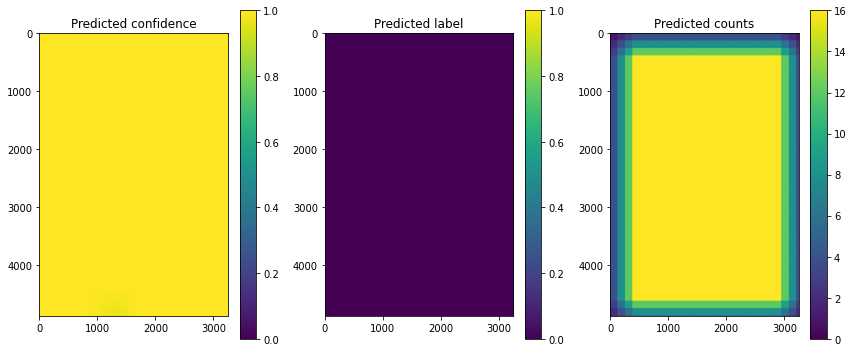

  0%|          | 4/1000 [00:32<2:13:32,  8.04s/it]

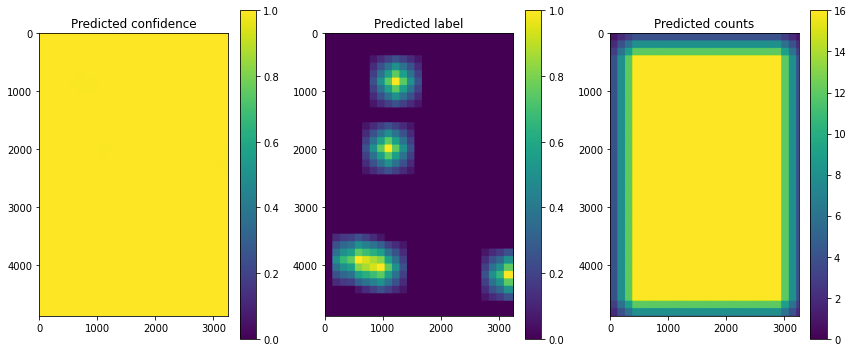

  0%|          | 5/1000 [00:40<2:14:20,  8.10s/it]

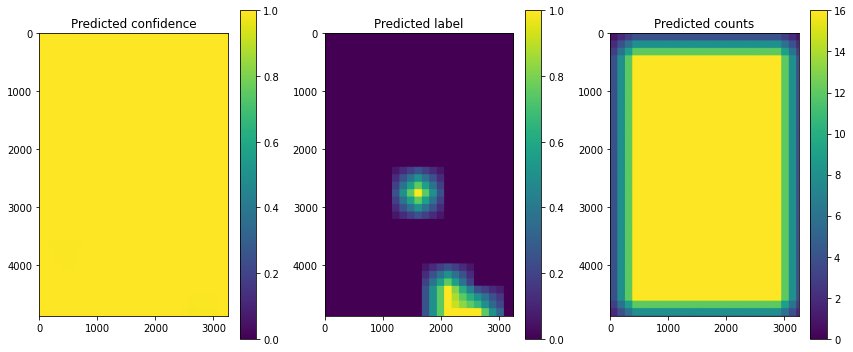

  1%|          | 6/1000 [00:48<2:13:29,  8.06s/it]

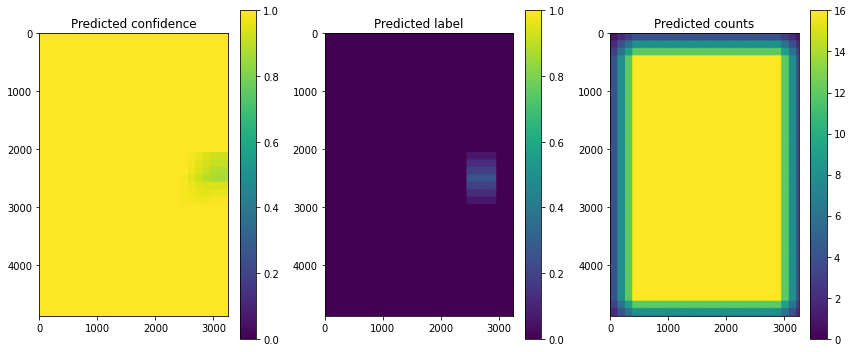

  1%|          | 7/1000 [00:56<2:13:13,  8.05s/it]

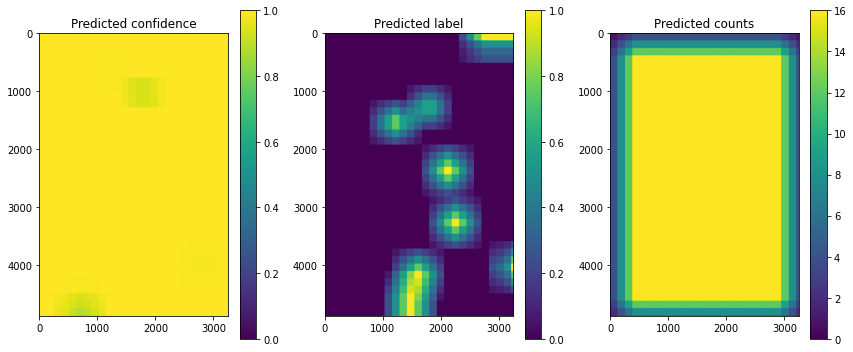

  1%|          | 8/1000 [01:04<2:13:41,  8.09s/it]

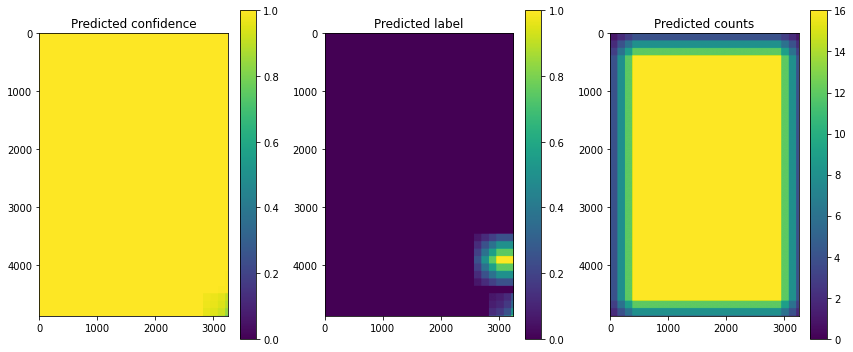

  1%|          | 9/1000 [01:12<2:13:07,  8.06s/it]

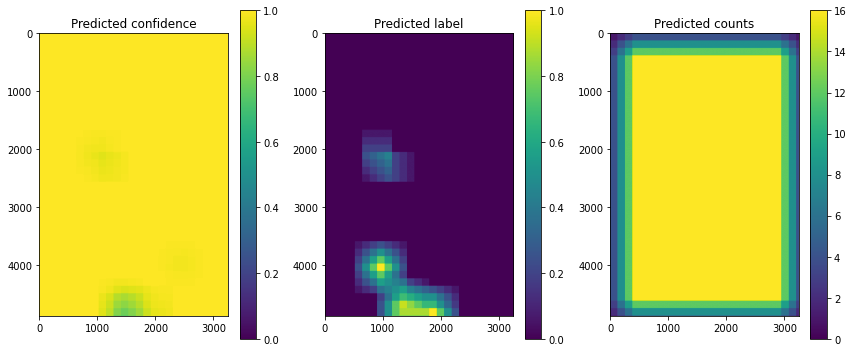

  1%|          | 10/1000 [01:20<2:12:43,  8.04s/it]

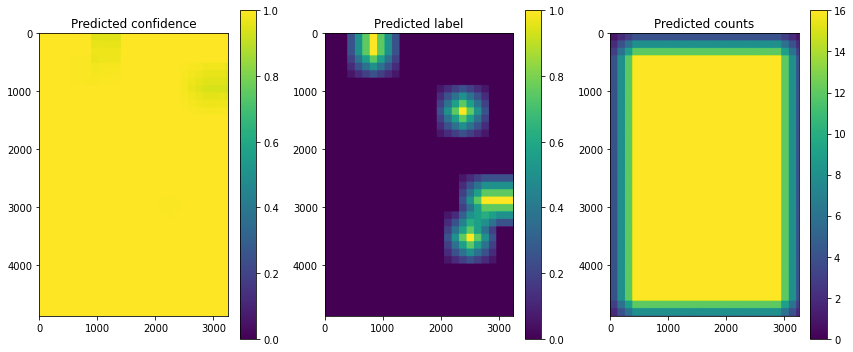

  1%|          | 11/1000 [01:28<2:12:33,  8.04s/it]

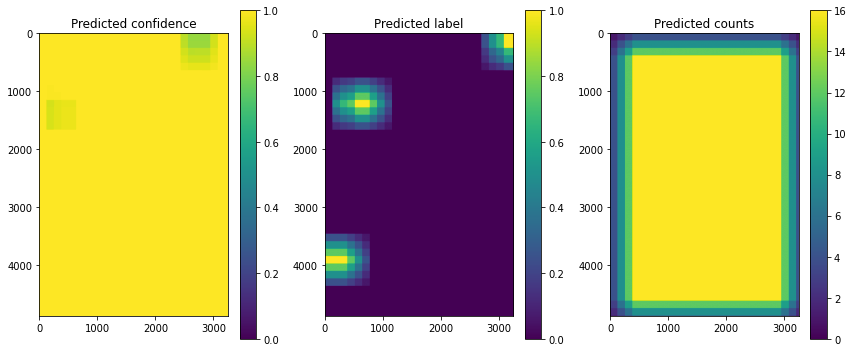

  1%|          | 12/1000 [01:36<2:12:51,  8.07s/it]

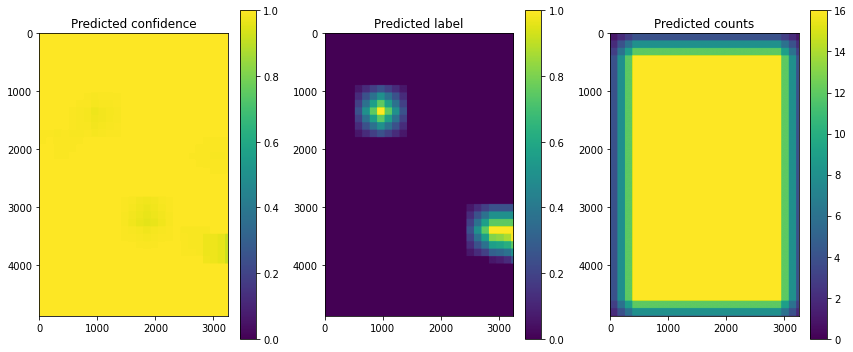

  1%|▏         | 13/1000 [01:44<2:12:18,  8.04s/it]

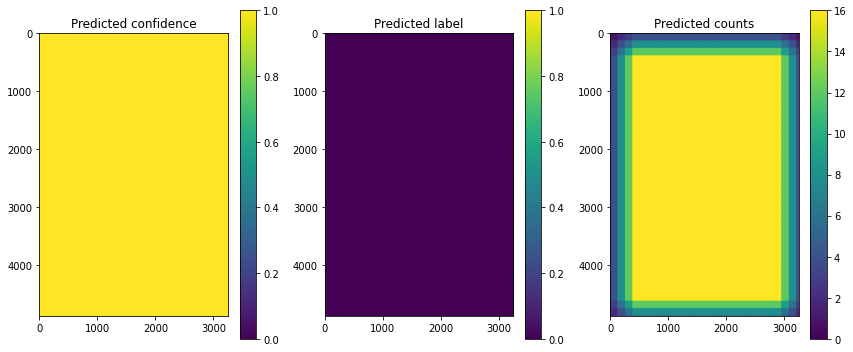

  1%|▏         | 14/1000 [01:52<2:11:57,  8.03s/it]

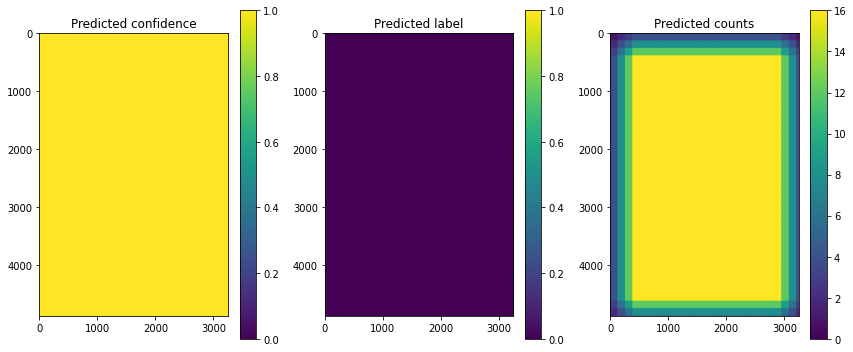

  2%|▏         | 15/1000 [02:00<2:11:36,  8.02s/it]

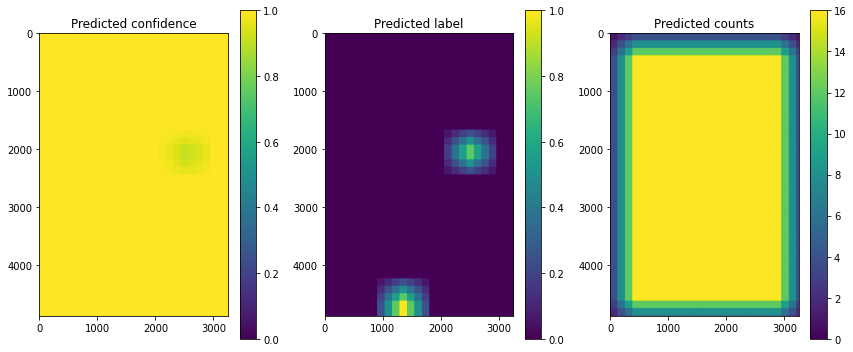

  2%|▏         | 16/1000 [02:08<2:12:01,  8.05s/it]

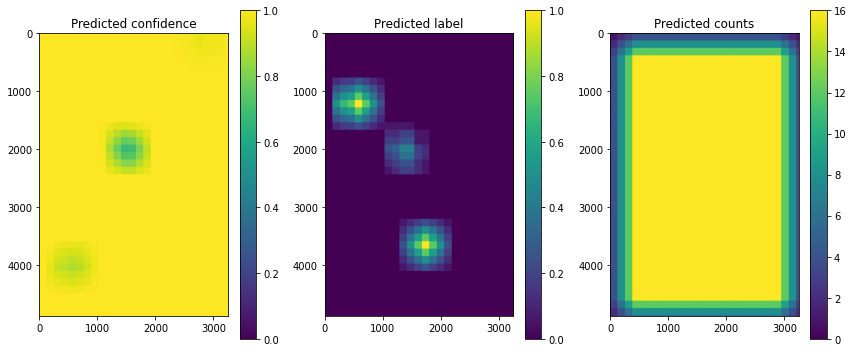

  2%|▏         | 17/1000 [02:16<2:11:40,  8.04s/it]

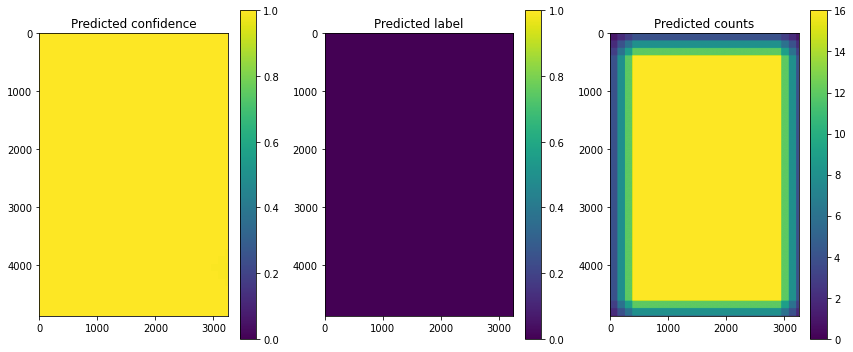

  2%|▏         | 18/1000 [02:24<2:11:18,  8.02s/it]

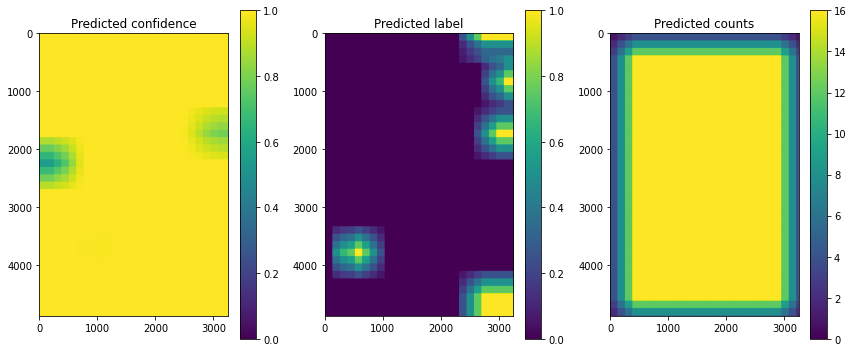

  2%|▏         | 19/1000 [02:32<2:11:26,  8.04s/it]

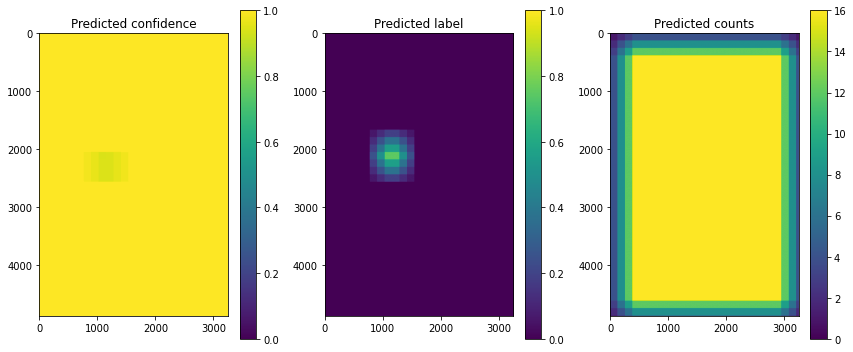

  2%|▏         | 20/1000 [02:41<2:11:46,  8.07s/it]

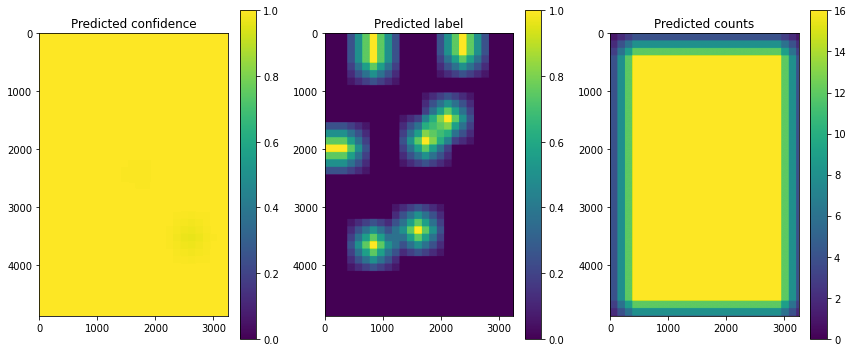

  2%|▏         | 21/1000 [02:49<2:11:39,  8.07s/it]

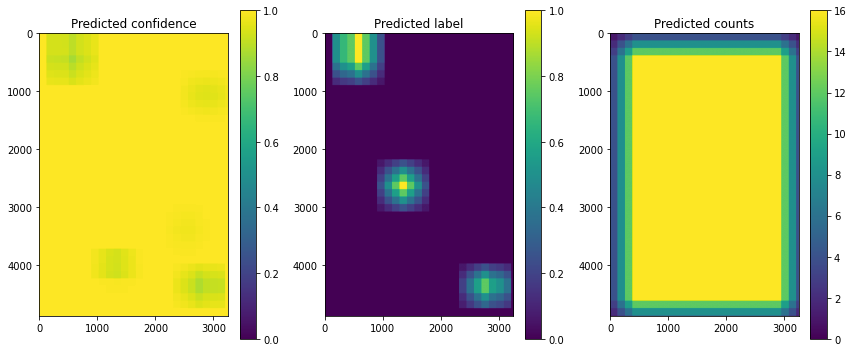

  2%|▏         | 22/1000 [02:57<2:11:11,  8.05s/it]

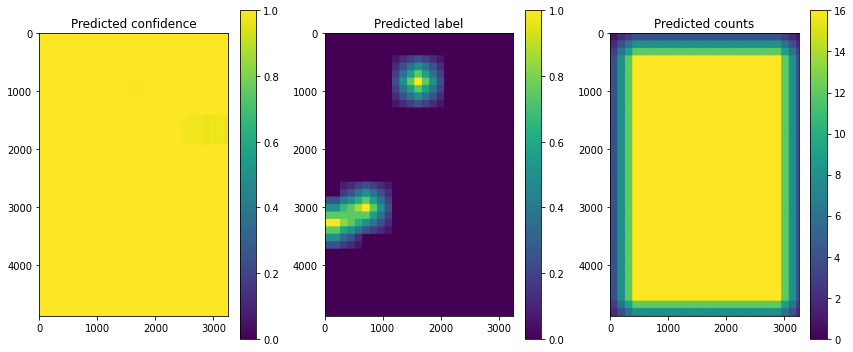

  2%|▏         | 23/1000 [03:05<2:10:50,  8.04s/it]

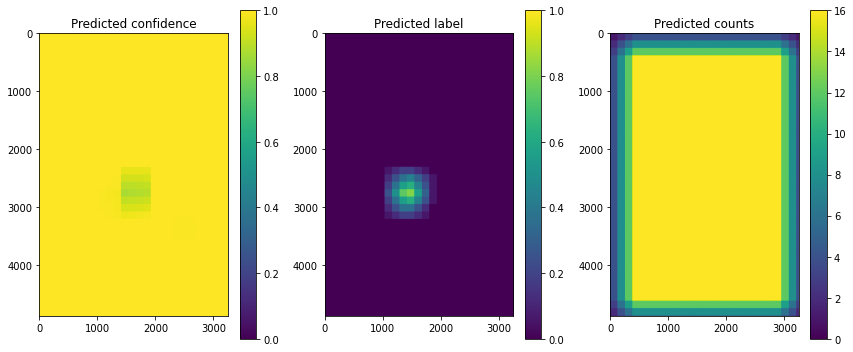

  2%|▏         | 24/1000 [03:13<2:11:07,  8.06s/it]

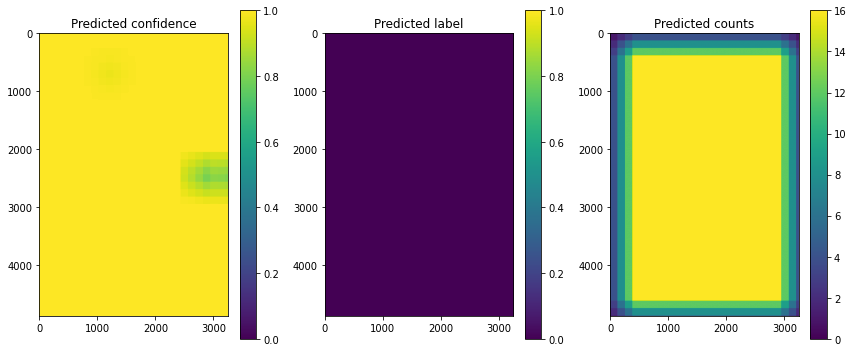

  2%|▎         | 25/1000 [03:21<2:10:31,  8.03s/it]

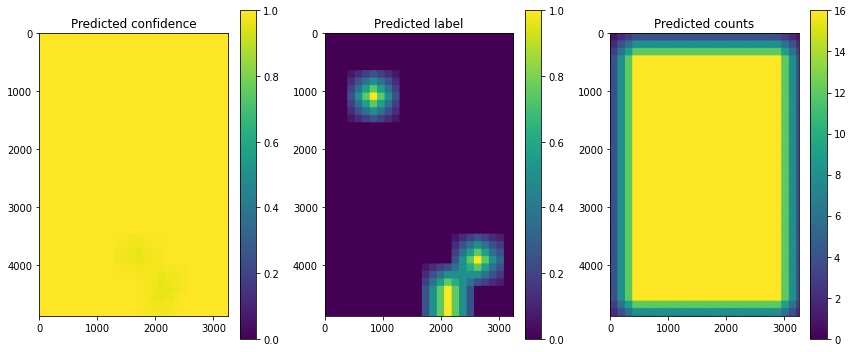

  3%|▎         | 26/1000 [03:29<2:10:21,  8.03s/it]

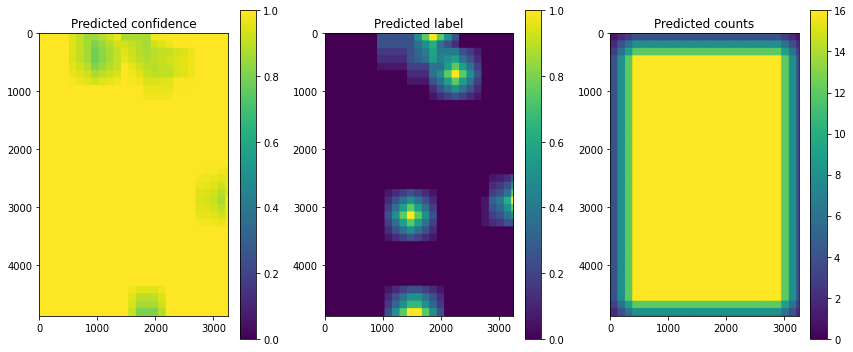

  3%|▎         | 27/1000 [03:37<2:10:21,  8.04s/it]

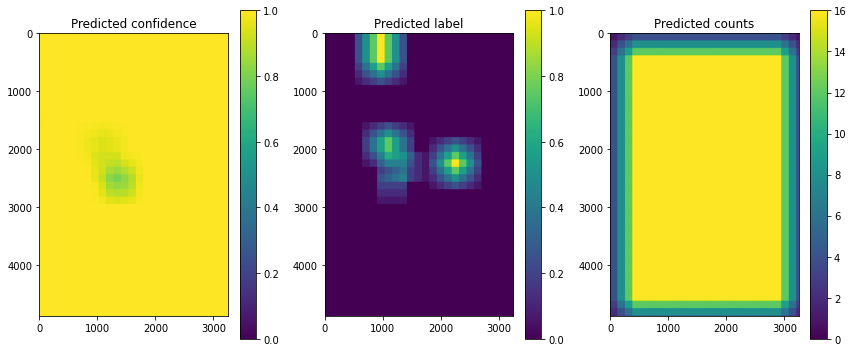

  3%|▎         | 28/1000 [03:45<2:10:40,  8.07s/it]

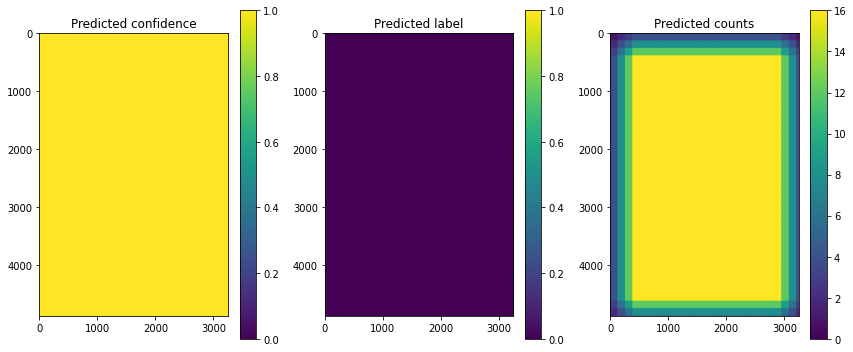

  3%|▎         | 29/1000 [03:53<2:10:22,  8.06s/it]

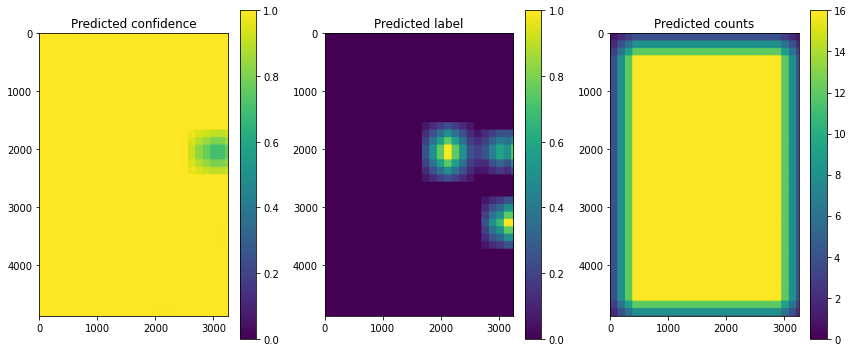

  3%|▎         | 30/1000 [04:01<2:10:05,  8.05s/it]

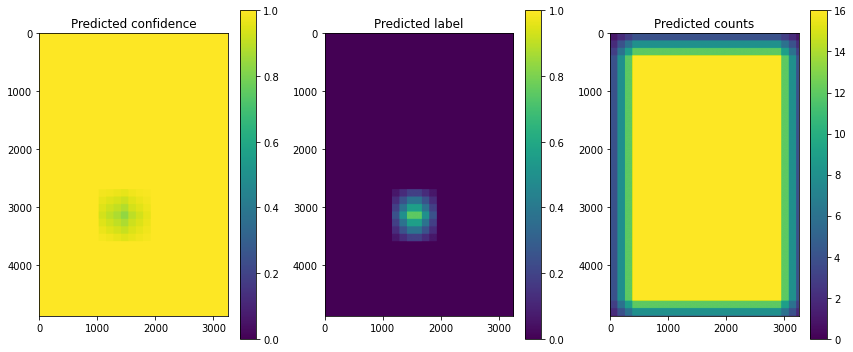

  3%|▎         | 31/1000 [04:09<2:09:38,  8.03s/it]

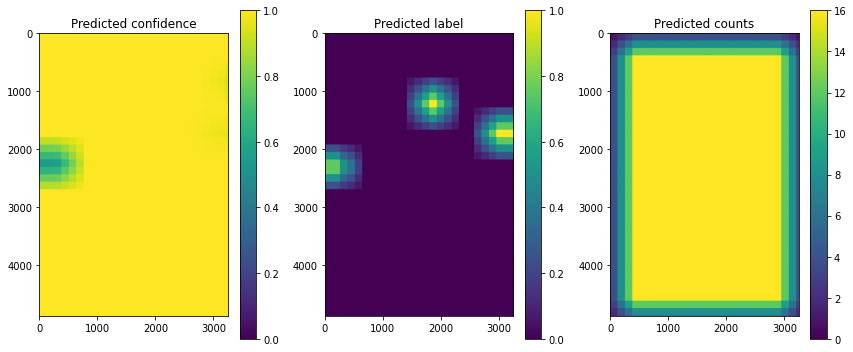

  3%|▎         | 32/1000 [04:17<2:10:27,  8.09s/it]

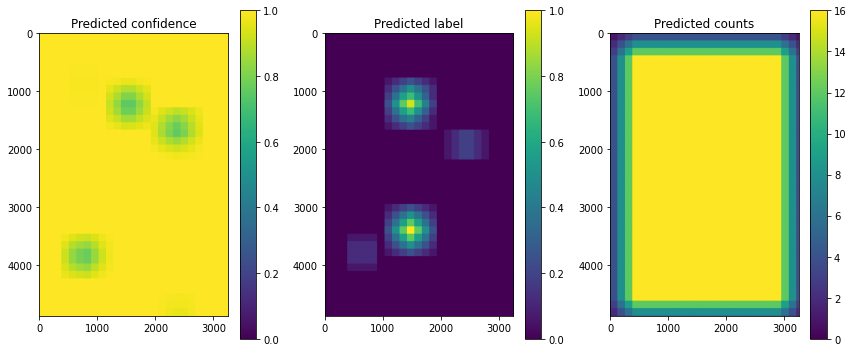

  3%|▎         | 33/1000 [04:25<2:09:55,  8.06s/it]

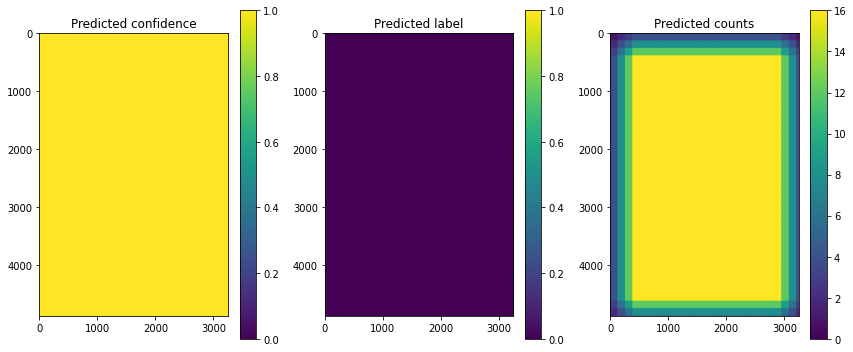

  3%|▎         | 34/1000 [04:33<2:09:34,  8.05s/it]

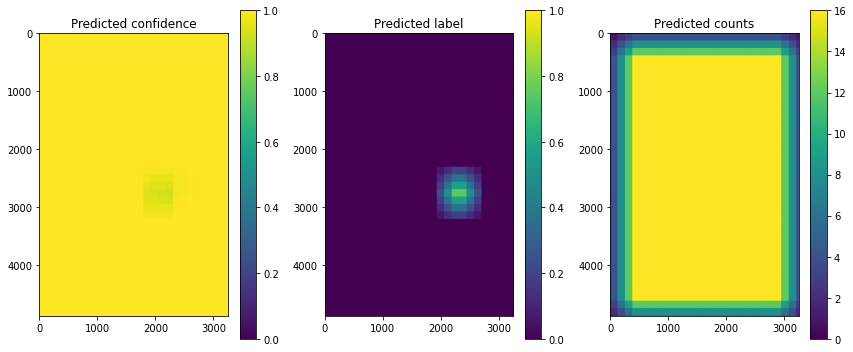

  4%|▎         | 35/1000 [04:41<2:09:24,  8.05s/it]

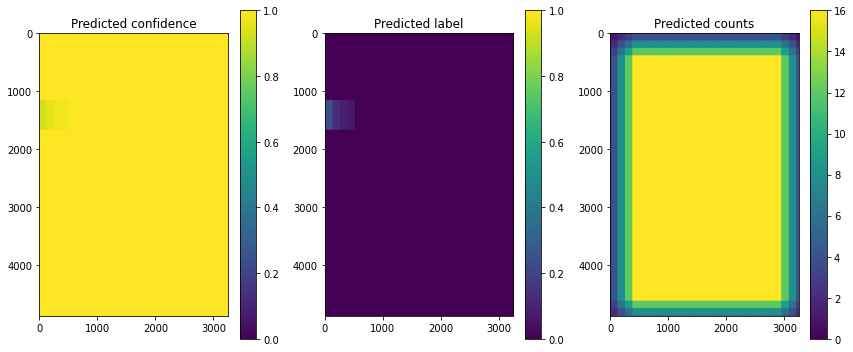

  4%|▎         | 36/1000 [04:49<2:09:46,  8.08s/it]

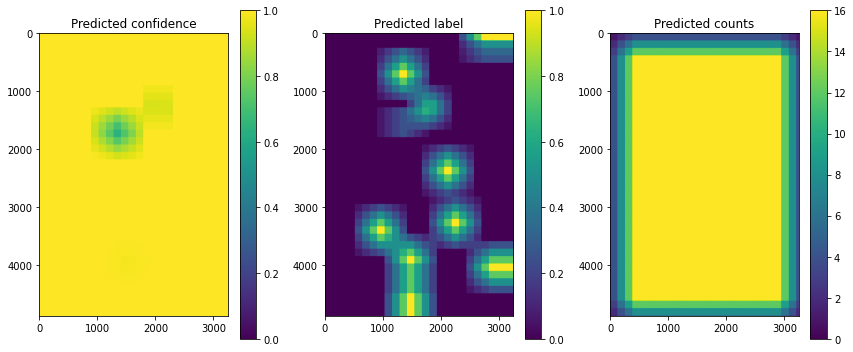

  4%|▎         | 37/1000 [04:57<2:09:35,  8.07s/it]

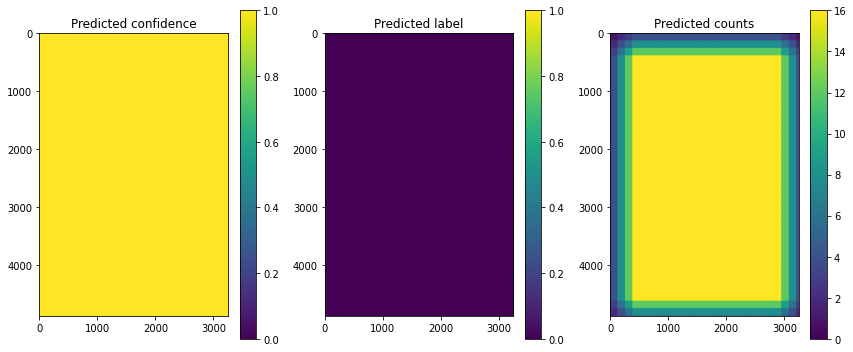

  4%|▍         | 38/1000 [05:05<2:09:05,  8.05s/it]

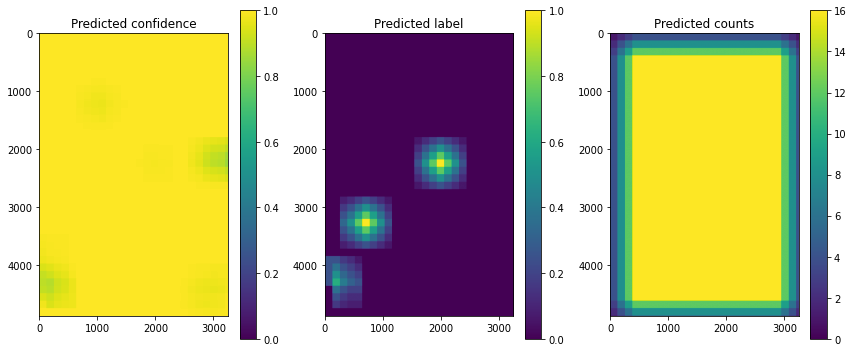

  4%|▍         | 39/1000 [05:13<2:08:39,  8.03s/it]

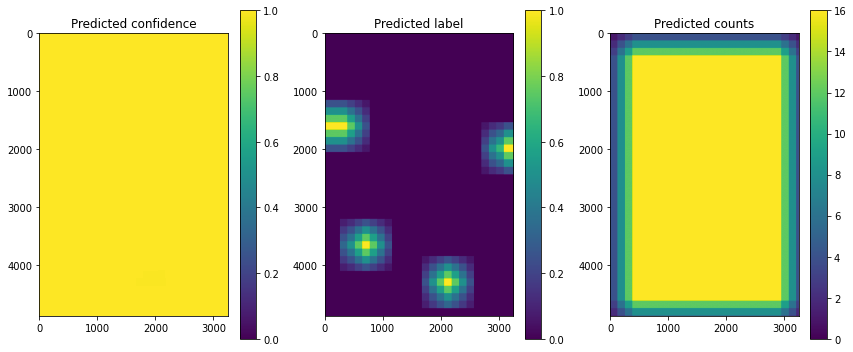

  4%|▍         | 40/1000 [05:22<2:09:16,  8.08s/it]

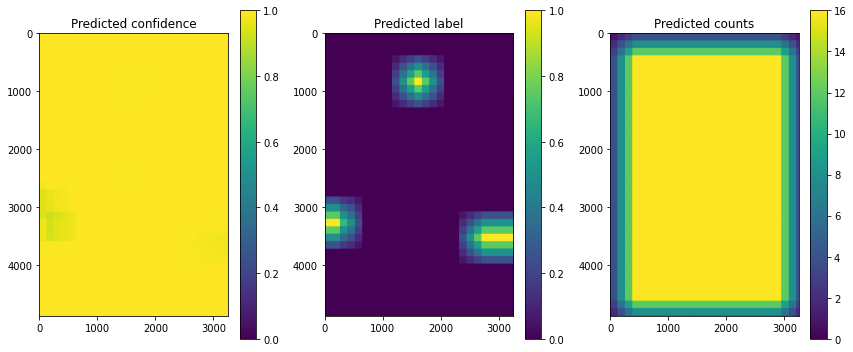

  4%|▍         | 41/1000 [05:30<2:08:56,  8.07s/it]

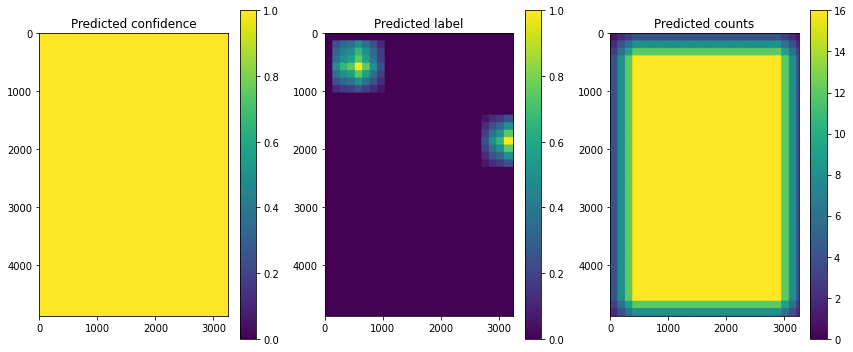

  4%|▍         | 42/1000 [05:38<2:08:28,  8.05s/it]

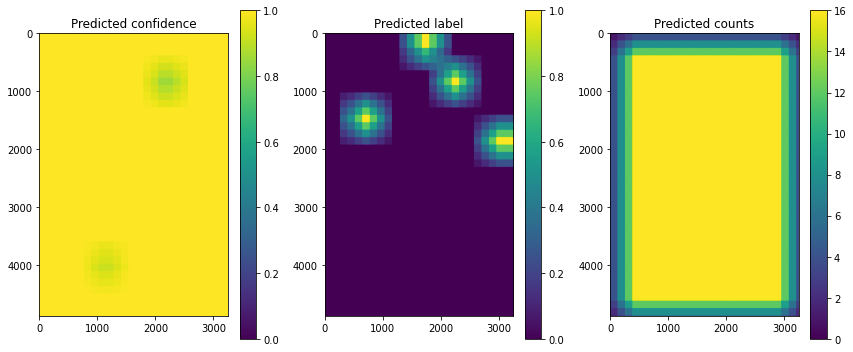

  4%|▍         | 43/1000 [05:46<2:08:25,  8.05s/it]

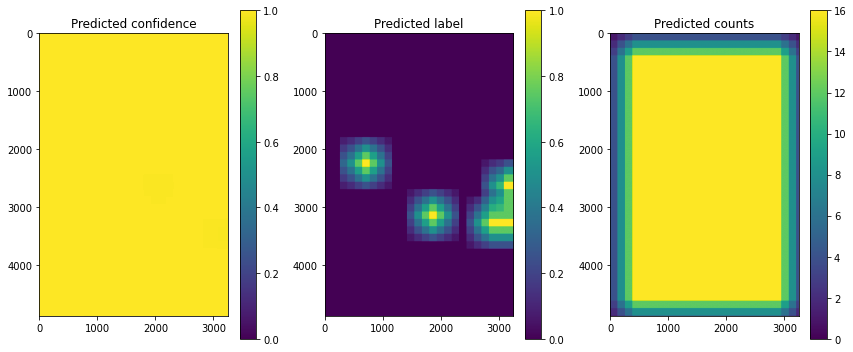

  4%|▍         | 44/1000 [05:54<2:08:48,  8.08s/it]

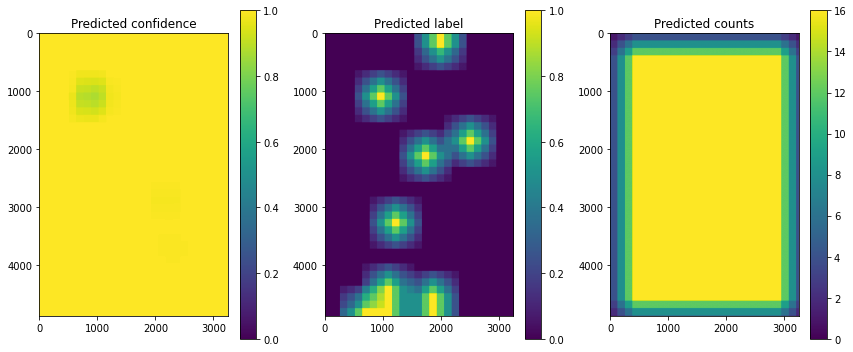

  4%|▍         | 45/1000 [06:02<2:08:43,  8.09s/it]

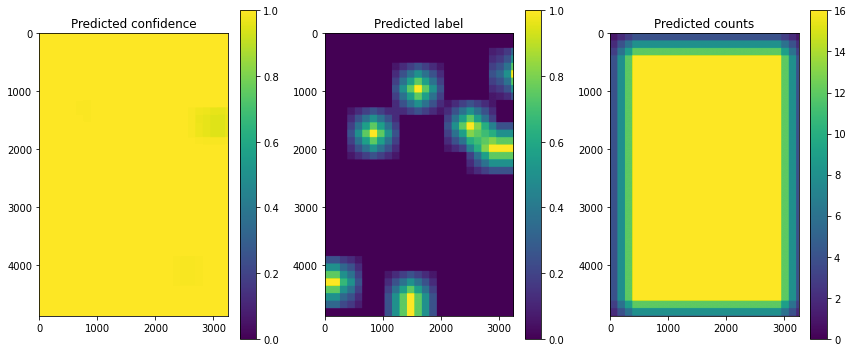

  5%|▍         | 46/1000 [06:10<2:08:05,  8.06s/it]

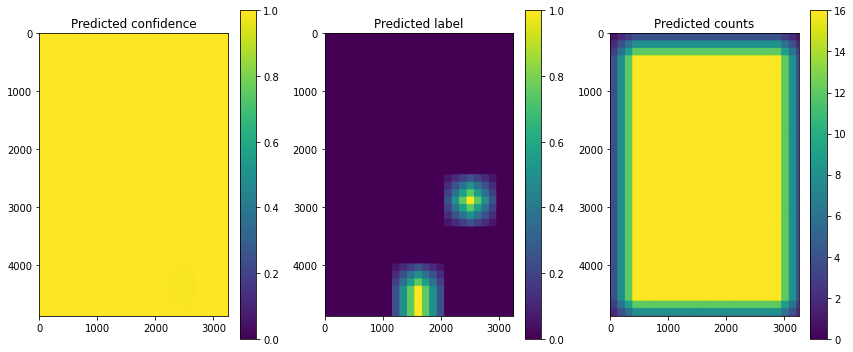

  5%|▍         | 47/1000 [06:18<2:07:43,  8.04s/it]

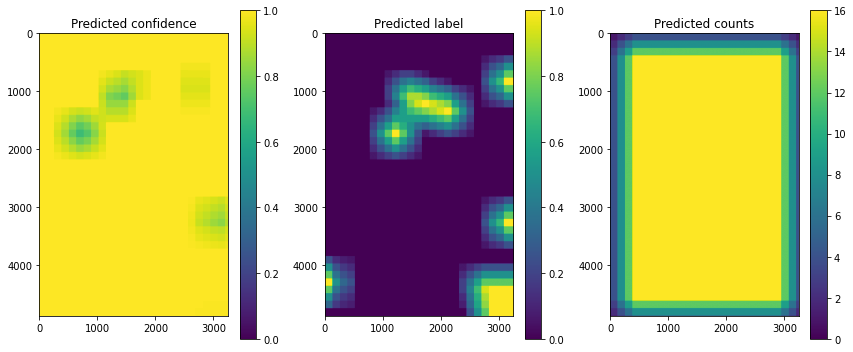

  5%|▍         | 48/1000 [06:26<2:08:25,  8.09s/it]

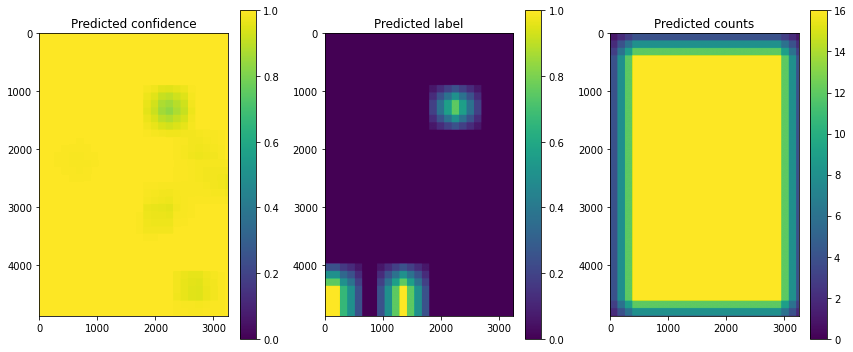

  5%|▍         | 49/1000 [06:34<2:07:57,  8.07s/it]

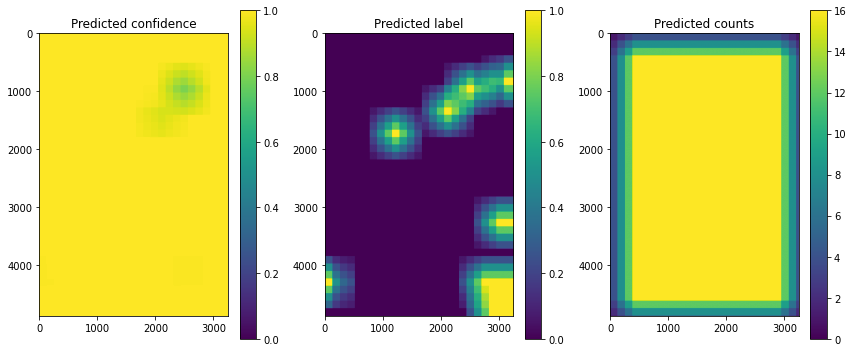

  5%|▌         | 50/1000 [06:42<2:07:32,  8.06s/it]


In [48]:
inference_batch_size = 128
#results_dict = {}

prob_results = {}
label_results = {}

model.eval()
with torch.no_grad():
    for (sub_images, image_index_lst, image_coords, image_z) in tqdm.tqdm(inference_generator, total = len(z_list)):

        def data_gen():
            for i in range(0, len(sub_images), inference_batch_size):
                yield (
                    sub_images[i:i+inference_batch_size],
                    image_index_lst[i:i+inference_batch_size],
                    image_coords[i:i+inference_batch_size],
                    image_z[i:i+inference_batch_size]
                )

        results_dict = {}
        for p, (sub_image, index, coords, z) in enumerate(data_gen()):
            tile_coordinates = np.hstack([coords, np.expand_dims(z, 1)])
            sub_image = torch.cat([torch.from_numpy(x).float().unsqueeze(0) for x in sub_image])
            sub_image = sub_image.to(device)
            image = torch.abs(sub_image).unsqueeze(1)
            phase = torch.angle(sub_image).unsqueeze(1)
            stacked_image = torch.cat([image, phase], 1)

            pred_logits = model(stacked_image)
            pred_probs, pred_labels = torch.max(pred_logits, 1)
            pred_probs = pred_probs.exp()
                        
            for coor, key, prob, label in zip(tile_coordinates, index, pred_probs, pred_labels):
                results_dict[tuple(list(key))] = [prob.item(), label.item()] + list(coor)
                
        # Make a plot
        z_indices = sorted(list(set([x[2] for x in results_dict.keys()])))
        for z_idx in z_indices:

            labels = np.zeros(test_image.shape)
            probs = np.zeros(test_image.shape)
            counter = np.zeros(test_image.shape)

            for row_idx in range(labels.shape[0] // step_size):

                if row_idx*step_size+tile_size > labels.shape[0]:
                    row_slice = slice(row_idx*step_size, row_idx*step_size+labels.shape[0]) #slice(-tile_size,None)
                    row_break = True
                else:
                    row_slice = slice(row_idx*step_size,row_idx*step_size+tile_size)
                    row_break = False

                for col_idx in range(labels.shape[1]//step_size):

                    if col_idx*step_size+tile_size > labels.shape[1]:
                        col_slice = slice(col_idx*step_size, labels.shape[1]) #slice(-tile_size, None)
                        col_break = True
                    else:
                        col_slice = slice(col_idx*step_size,col_idx*step_size+tile_size)
                        col_break = False

                    counter[row_slice, col_slice] += 1
                    labels[row_slice, col_slice] += results_dict[row_idx, col_idx, z_idx][1]
                    probs[row_slice, col_slice] += results_dict[row_idx, col_idx, z_idx][0]

                    if col_break:
                        break

                if row_break:
                    break

            labels /= counter
            probs /= counter

            fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 5))

            p1 = ax0.imshow(probs, vmin = 0,  vmax = 1)
            ax0.set_title("Predicted confidence")
            fig.colorbar(p1, ax=ax0)

            p2 = ax1.imshow(labels, vmin = 0, vmax = 1)
            ax1.set_title("Predicted label")
            fig.colorbar(p2, ax=ax1)

            p3 = ax2.imshow(counter, vmin = 0, vmax = np.amax(counter))
            ax2.set_title("Predicted counts")
            fig.colorbar(p3, ax=ax2)

            plt.tight_layout()
            plt.show()
            
            prob_results[z_idx] = probs
            label_results[z_idx] = labels

In [80]:
average_prob = np.vstack([np.expand_dims(x, 0) for x in prob_results.values()])
average_label = np.vstack([np.expand_dims(x, 0) for x in label_results.values()])
in_focus_prob = [l * (1-p) + l * p for l,p in zip(label_results.values(), prob_results.values())]
in_focus_prob = np.vstack([np.expand_dims(x, 0) for x in in_focus_prob])

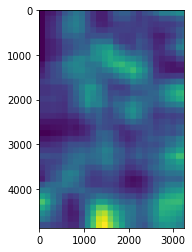

In [83]:
plt.imshow(np.sum(in_focus_prob, 0))

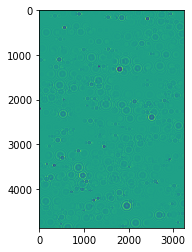

In [76]:
plt.imshow(test_image.values)

In [43]:
# z_indices = sorted(list(set([x[2] for x in results_dict.keys()])))

# for z_idx in z_indices:
    
#     labels = np.zeros(test_image.shape)
#     probs = np.zeros(test_image.shape)
#     counter = np.zeros(test_image.shape)
    
#     for row_idx in range(labels.shape[0] // step_size):

#         if row_idx*step_size+tile_size > labels.shape[0]:
#             row_slice = slice(row_idx*step_size, row_idx*step_size+labels.shape[0]) #slice(-tile_size,None)
#             row_break = True
#         else:
#             row_slice = slice(row_idx*step_size,row_idx*step_size+tile_size)
#             row_break = False

#         for col_idx in range(labels.shape[1]//step_size):

#             if col_idx*step_size+tile_size > labels.shape[1]:
#                 col_slice = slice(col_idx*step_size, labels.shape[1]) #slice(-tile_size, None)
#                 col_break = True
#             else:
#                 col_slice = slice(col_idx*step_size,col_idx*step_size+tile_size)
#                 col_break = False

#             counter[row_slice, col_slice] += 1
#             labels[row_slice, col_slice] += results_dict[row_idx, col_idx, z_idx][1]
#             probs[row_slice, col_slice] += results_dict[row_idx, col_idx, z_idx][0]

#             if col_break:
#                 break

#         if row_break:
#             break

#     labels /= counter
#     probs /= counter
    
#     fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 5))

#     p1 = ax0.imshow(probs, vmin = 0,  vmax = 1)
#     ax0.set_title("Predicted confidence")
#     fig.colorbar(p1, ax=ax0)

#     p2 = ax1.imshow(labels, vmin = 0, vmax = 1)
#     ax1.set_title("Predicted label")
#     fig.colorbar(p2, ax=ax1)

#     p3 = ax2.imshow(counter, vmin = 0, vmax = np.amax(counter))
#     ax2.set_title("Predicted counts")
#     fig.colorbar(p3, ax=ax2)

#     plt.tight_layout()
#     plt.show()

In [31]:
# xs = [x[1][2] for x in results_dict.items()]
# ys = [x[1][3] for x in results_dict.items()]
#plt.scatter(xs, ys)

In [32]:
# # parallelize the propagation step

# import multiprocessing as mp

# def worker(shared_queue = None, image = None, batch_size = 32, z_lst = None):
#     with torch.no_grad():
#         gen = get_next_z_planes(image, z_lst)
#         for (sub_images, image_index_lst, image_coords, image_z) in gen:
#             # use a generator to create batches
#             def data_gen():
#                 for i in range(0, len(sub_images), batch_size):
#                     yield (
#                         sub_images[i:i+batch_size],
#                         image_index_lst[i:i+batch_size],
#                         image_coords[i:i+batch_size],
#                         image_z[i:i+batch_size]
#                     )
#             for (sub_image, index, coords, z) in data_gen():
#                 # prep the input
#                 tile_coordinates = np.hstack([coords, np.expand_dims(z, 1)])
#                 image = np.expand_dims(np.abs(sub_image), 1)
#                 phase = np.expand_dims(np.angle(sub_image), 1)
#                 stacked_image = np.concatenate([image, phase], 1)
#                 # put onto a queue
#                 print("Putting stuff on the queue")
#                 shared_queue.put((stacked_image, index, tile_coordinates))
#     shared_queue.put("done")

In [33]:
# m = mp.Manager()
# q = m.Queue()
  
# inference_batch_size = 32
# pool = mp.Pool(1, worker, (q, test_image, inference_batch_size, [z_lst[0]],))

# # with mp.Pool(2) as p:
# #     test_image = h_ds['image'].isel(hologram_number=h_idx)
# #     work = partial(q, worker, test_image, inference_batch_size)
# #     for result in p.imap(work, z_lst[0:2]):
# #         results.append(result)

# pool.close()
# pool.join_thread()

In [54]:
#list(results_dict.keys())

In [67]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [68]:
total_params

23508994